# Obrada financijskih podataka

In [63]:
import pandas as pd
import scipy.stats as sc
import scipy.optimize as so
import numpy as np
import matplotlib.pyplot as plt
yahoo="https://finance.yahoo.com/quote/%5EGSPC/history?period1=-630982800&period2=1557525600&interval=1mo&filter=history&frequency=1mo"

In [18]:
tables = pd.read_html(yahoo,parse_dates=True)[0] # Uzeli smo nulti element jer je ostalo višak 
# koji nije prepoznao
# Parse dates prepoznaje datume

Financijski podaci koji nas zanimaju su vrijednost pri otvaranju dana (Open), najmanja i najveća vrijednost.
Datum je kolumna Date.
Uzimamo samo numeričke vrijednosti

In [24]:
tables=tables[:100] # 100. redak je nenumerički i odbacujemo ga

Popis kolumni

In [27]:
tables.columns

Index(['Date', 'Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume'], dtype='object')

Pretvaranje stringova u float

In [32]:
for c in ['Open', 'High', 'Low', 'Close*', 'Adj Close**', 'Volume']:
    tables[c]=tables[c].astype(float) # Iako je astype numpy metoda
    # Pandas nasljeđuje numpy!
for c in ["Date"]:
    tables[c] = pd.to_datetime(tables[c], infer_datetime_format=True)

Tablica je posložena vremenski obrnuto.

In [37]:
tables["Date"][1]-tables["Date"][0]

Timedelta('-9 days +00:00:00')

Sortiranje po određenoj kolumni

In [38]:
tables = tables.sort_values("Date")

Inkrementalni porast kolumni
np.diff

In [47]:
tables["dOpen"]=np.nan
tables["dHigh"]=np.nan
tables["dLow"]=np.nan
tables["dOpen"][1:]=np.diff(tables["Open"])
tables["dHigh"][1:]=np.diff(tables["High"])
tables["dLow"][1:]=np.diff(tables["Low"])

/home/marko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.
/home/marko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/home/marko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


Budući da tablica ima prazne vrijednosti (NAN), njih filtiriramo s dropna() metodom
## Histogram

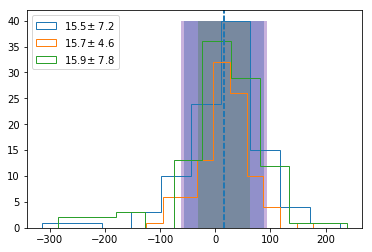

In [62]:
f, ax = plt.subplots(1,1)
srednje_vrijednosti = [np.mean(tables[c]) for c in ["dOpen","dHigh","dLow"]]
std_vrijedosti = [np.std(tables[c],ddof=1) for c in ["dOpen","dHigh","dLow"]]
for i in range(3):
    c = ["dOpen","dHigh","dLow"][i]
    
    ax.axvline(srednje_vrijednosti[i], ls="dashed")
    ax.fill_between([srednje_vrijednosti[i]-std_vrijedosti[i],
                     srednje_vrijednosti[i]+std_vrijedosti[i]],0,40,alpha=.5)
    ax.hist(tables[c].dropna(),histtype="step",
           label="%.1f$\pm$ %.1f"%(srednje_vrijednosti[i],std_vrijedosti[i]/np.sqrt(np.size(tables[c]))))
ax.legend()

Sve tri distribucije nisu normalne, niti su nenagnute i bez kurtoze (K!=3)

In [67]:
for c in ["dOpen","dHigh","dLow"]:
    for f in [sc.skewtest,sc.kurtosistest, sc.normaltest]:
        print(c, f(tables[c].dropna())[1])

dOpen 9.270631071167169e-05
dOpen 4.891348846769093e-05
dOpen 1.2628269999035125e-07
dHigh 0.39094014038007374
dHigh 0.015860872765667396
dHigh 0.0377366187250862
dLow 1.3610848841926895e-05
dLow 0.00012262715484679423
dLow 4.871014719189368e-08


In [69]:
sc.kstest(tables[c].dropna(),"levy")

KstestResult(statistic=0.3849029493935431, pvalue=1.0466511979195285e-13)

Prilagodba gausijana na histogram

KstestResult(statistic=0.09406494309614022, pvalue=0.32591540331105745)
KstestResult(statistic=0.09029894666284335, pvalue=0.3749720468639463)
KstestResult(statistic=0.1473765417861435, pvalue=0.02429657952751952)


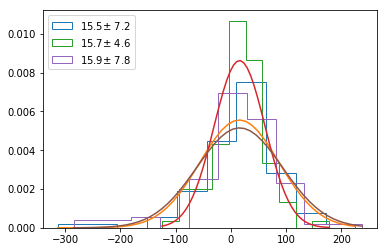

In [81]:
f, ax = plt.subplots(1,1)
srednje_vrijednosti = [np.mean(tables[c]) for c in ["dOpen","dHigh","dLow"]]
std_vrijedosti = [np.std(tables[c],ddof=1) for c in ["dOpen","dHigh","dLow"]]
for i in range(3):
    c = ["dOpen","dHigh","dLow"][i]
    
    ax.hist(tables[c].dropna(),histtype="step",
           label="%.1f$\pm$ %.1f"%(srednje_vrijednosti[i],std_vrijedosti[i]/np.sqrt(np.size(tables[c]))),
           normed=True) # Normiramo histogram
    bf = sc.norm.fit(tables[c].dropna()) # Određuje best-fit parametre
    x  = np.linspace(tables[c].dropna().min(),
                     tables[c].dropna().max()) # Izračunava x os
    ax.plot(x, sc.norm.pdf(x,*bf)) # Primjenjuje best-fit parametre
    print(sc.kstest(tables[c].dropna(),"norm",args=bf))
ax.legend()

KstestResult(statistic=0.05453324862601927, pvalue=0.9300546745145792)
KstestResult(statistic=0.042232081443793416, pvalue=0.994489102190674)
KstestResult(statistic=0.05659882096763158, pvalue=0.9090045318875042)


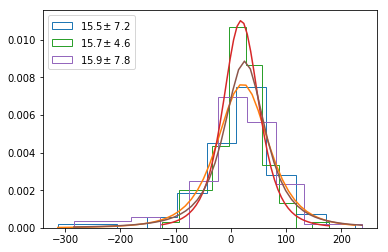

In [80]:
f, ax = plt.subplots(1,1)
srednje_vrijednosti = [np.mean(tables[c]) for c in ["dOpen","dHigh","dLow"]]
std_vrijedosti = [np.std(tables[c],ddof=1) for c in ["dOpen","dHigh","dLow"]]
for i in range(3):
    c = ["dOpen","dHigh","dLow"][i]
    
    ax.hist(tables[c].dropna(),histtype="step",
           label="%.1f$\pm$ %.1f"%(srednje_vrijednosti[i],std_vrijedosti[i]/np.sqrt(np.size(tables[c]))),
           normed=True) # Normiramo histogram
    bf = sc.t.fit(tables[c].dropna()) # Određuje best-fit parametre
    x  = np.linspace(tables[c].dropna().min(),
                     tables[c].dropna().max()) # Izračunava x os
    ax.plot(x, sc.t.pdf(x,*bf)) # Primjenjuje best-fit parametre
    print(sc.kstest(tables[c].dropna(),"t",args=bf))
ax.legend()

KstestResult(statistic=0.5495714919406773, pvalue=1.3268778449935657e-28)
KstestResult(statistic=0.4965379487463749, pvalue=4.501395556662433e-23)
KstestResult(statistic=0.5336169354476162, pvalue=7.362557392432769e-27)


/home/marko/miniconda3/lib/python3.7/site-packages/scipy/stats/_distn_infrastructure.py:2316: RuntimeWarning: invalid value encountered in double_scalars
  Lhat = muhat - Shat*mu


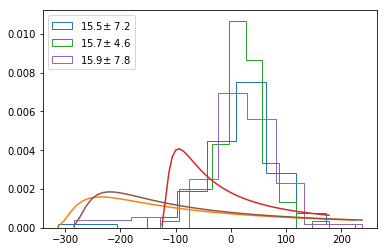

In [83]:
f, ax = plt.subplots(1,1)
srednje_vrijednosti = [np.mean(tables[c]) for c in ["dOpen","dHigh","dLow"]]
std_vrijedosti = [np.std(tables[c],ddof=1) for c in ["dOpen","dHigh","dLow"]]
for i in range(3):
    c = ["dOpen","dHigh","dLow"][i]
    
    ax.hist(tables[c].dropna(),histtype="step",
           label="%.1f$\pm$ %.1f"%(srednje_vrijednosti[i],std_vrijedosti[i]/np.sqrt(np.size(tables[c]))),
           normed=True) # Normiramo histogram
    bf = sc.levy.fit(tables[c].dropna()) # Određuje best-fit parametre
    x  = np.linspace(tables[c].dropna().min(),
                     tables[c].dropna().max()) # Izračunava x os
    ax.plot(x, sc.levy.pdf(x,*bf)) # Primjenjuje best-fit parametre
    print(sc.kstest(tables[c].dropna(),"levy",args=bf))
ax.legend()

## Vremenski nizovi


/home/marko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/marko/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: RuntimeWarning: invalid value encountered in sqrt
  This is separate from the ipykernel package so we can avoid doing imports until


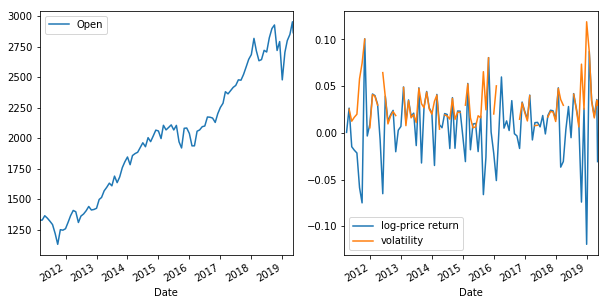

In [100]:
tables["log-price return"] = np.nan
tables["log-price return"][1:]=np.diff(np.log(tables["Open"]))
tables["volatility"]=np.sqrt(tables["log-price return"]**2-np.mean(tables["log-price return"])**2)
f,ax=plt.subplots(1,2,figsize=(10,5))
tables.plot(x="Date",y="Open",ax=ax[0])
tables.plot(x="Date",y="log-price return",ax=ax[1])
tables.plot(x="Date",y="volatility",ax=ax[1])

In [101]:
np.mean(tables["log-price return"])

0.0077550413255309085